# MIR LSSM for Kex

> Ensembling Resnet, ... to predict exchangeable potassium in soil

In [ ]:
%load_ext autoreload
%autoreload 2

## Imports

In [ ]:
from pathlib import Path
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import timm
from torcheval.metrics import R2Score
from torch.optim import lr_scheduler
from torch import optim, nn

from lssm.loading import load_ossl
from lssm.preprocessing import ToAbsorbance, ContinuumRemoval, Log1p, SNV
from lssm.dataloaders import SpectralDataset, get_dls
from lssm.callbacks import (MetricsCB, BatchSchedCB, BatchTransformCB,
                            DeviceCB, TrainCB, ProgressCB)
from lssm.transforms import GADFTfm, _resizeTfm, StatsTfm
from lssm.learner import Learner


/Users/franckalbinet/mambaforge/envs/lssm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading & preprocessing

In [ ]:
analytes = 'k.ext_usda.a725_cmolc.kg'
spectra_type = 'mir'

data = load_ossl(analytes, spectra_type)
X, y, X_names, smp_idx, ds_name, ds_label = data

X = Pipeline([('to_abs', ToAbsorbance()),
              ('snv', SNV())]).fit_transform(X)
            #   ('cr', ContinuumRemoval(X_names))]).fit_transform(X)
             
y = Log1p().fit_transform(y)

Reading & selecting data ...


In [ ]:
# Train/valid split
n_smp = None  # For demo. purpose
X_train, X_valid, y_train, y_valid = train_test_split(X[:n_smp, :], y[:n_smp],
                                                      test_size=0.1,
                                                      stratify=ds_name[:n_smp],
                                                      random_state=41)

# Get PyTorch datasets
train_ds, valid_ds = [SpectralDataset(X, y, )
                      for X, y, in [(X_train, y_train), (X_valid, y_valid)]]

In [ ]:
# Then PyTorch dataloaders
dls = get_dls(train_ds, valid_ds, bs=1)

## DL model ensembling

In [ ]:
def apply_mod(m, f):
    f(m)
    for l in m.children(): apply_mod(l, f)

def set_grad(m, b):
    if isinstance(m, (nn.Linear,nn.BatchNorm2d)): return
    if hasattr(m, 'weight'):
        for p in m.parameters(): p.requires_grad_(b) 

In [ ]:
model_name = 'resnet18'
model = timm.create_model(model_name, pretrained=True,
                          in_chans=1, num_classes=1)

In [ ]:
apply_mod(model, partial(set_grad, b=False))

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

10113

In [ ]:
# Define modelling pipeline & Train
epochs = 3
lr = 5e-3

metrics = MetricsCB(r2=R2Score())

tmax = epochs * len(dls.train)

# xtra = [BatchSchedCB(sched)]

gadf = BatchTransformCB(GADFTfm())
resize = BatchTransformCB(_resizeTfm)
stats = BatchTransformCB(StatsTfm(model.default_cfg))

cbs = [DeviceCB(), gadf, resize, stats, TrainCB(),
       metrics, ProgressCB(plot=False)]

learn = Learner(model, dls, nn.MSELoss(), lr=lr,
                cbs=cbs, opt_func=optim.AdamW)

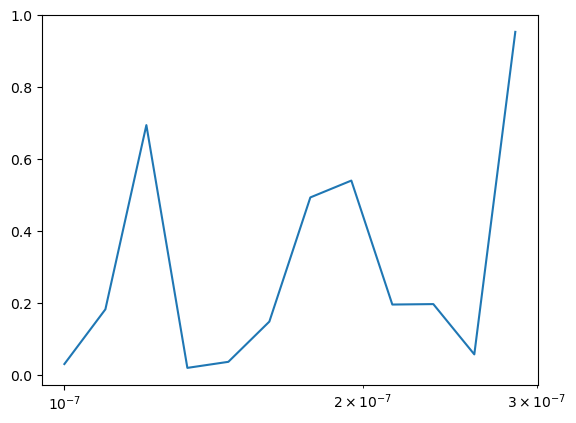

In [ ]:
learn.lr_find(start_lr=1e-7, gamma=1.1, max_mult=30)

In [ ]:
model_name = 'resnet18'
model = timm.create_model(model_name, pretrained=True,
                          in_chans=1, num_classes=1)

apply_mod(model, partial(set_grad, b=False))

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

513

In [ ]:
# Define modelling pipeline & Train
epochs = 3
lr = 1e-5

metrics = MetricsCB(r2=R2Score())

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

xtra = [BatchSchedCB(sched)]

gadf = BatchTransformCB(GADFTfm())
resize = BatchTransformCB(_resizeTfm)
stats = BatchTransformCB(StatsTfm(model.default_cfg))

cbs = [DeviceCB(), gadf, resize, stats, TrainCB(),
       metrics, ProgressCB(plot=False)]

learn = Learner(model, dls, nn.MSELoss(), lr=lr,
                cbs=cbs+xtra, opt_func=optim.AdamW)


In [ ]:
learn.fit(epochs)

KeyboardInterrupt: 